# 导入必要的库

In [1]:
import os 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import matlab.engine
import time
import scipy.io
import pandas as pd
import pickle
import scipy
import warnings
from accProcess import *
sns.set_style('ticks')
sns.set_context("poster")
plt.rcParams['font.sans-serif'] = 'Arial'
warnings.filterwarnings("ignore")
# matlabeng = matlab.engine.start_matlab()   #启动matlab

# 定义相关函数

In [2]:
def getProfile(filepath):
    f = open(filepath)
    data = f.readlines()
    f.close()
    data = data[2:]
    profile = np.zeros((len(data), 3))
    for i, line in enumerate(data):
        line = line.replace('\n', '').replace(',', ' ').split()
        profile[i, 1] = float(line[3])
        profile[i, 2] = float(line[4])
        if i < len(data) - 1:
            profile[i, 0] = float(line[2])
        else:
            profile[i, 0] = -1
    return profile


def transferProfile(profile, depth):
    vpvs = np.zeros((1500, 2))
    vpvs[:int(profile[0, 0]), 0] = profile[0, 1]
    vpvs[:int(profile[0, 0]), 1] = profile[0, 2]
    for i in range(1, profile.shape[0]):
        vpvs[int(profile[i - 1, 0]) : int(profile[i, 0]), 0] = profile[i, 1]
        vpvs[int(profile[i - 1, 0]) : int(profile[i, 0]), 1] = profile[i, 2]
    vpvs[int(profile[-2, 0]):, 0] = profile[-1, 1]
    vpvs[int(profile[-2, 0]):, 1] = profile[-1, 2]
    return vpvs[depth - 1, :]


def getVsVpdata(filepath, depth):
    profile = getProfile(filepath)
    return transferProfile(profile, depth)


def getVsDepth(profile, depth):
    if profile[0, 0] >= depth:
        vs_depth = profile[0, 2]
    else:
        t = profile[0, 0] / profile[0, 2]
        for i in range(1, profile.shape[0]):
            if profile[i, 0] <= depth:
                t += (profile[i, 0] - profile[i - 1, 0]) / profile[i, 2]
            else:
                t += (depth - profile[i - 1, 0]) / profile[i, 2]
                break
        vs_depth = depth / t
    return vs_depth

# 加载表格数据

In [ ]:
fpath = 'E:/Ground_motion_database/KiK-net'
event_data = pd.read_excel(os.path.join(fpath, 'RecordFile_raw.xlsx'))
event_data = event_data.sort_values(by=['Record code'])

# 筛选需要的台站
选择地震记录在10条以上以及有波速数据记录的台站

In [ ]:
station_selec = []
station_unsec = []
station_event = {}
event_list= []
station = event_data.iloc[0]['Station code']
pbar = tqdm(event_data['Record code'], desc='Calculating', ncols=100)
for i, event in enumerate(pbar):
    pbar.set_description(station)
    if event_data.iloc[i]['Station code'] == station:
        event_list.append(event)
    else:
        if len(event_list) > 10 and os.path.exists(os.path.join(fpath, 'sitedat_vs_vp', station + '.dat')):
            station_selec.append(station)
            station_event[station] = event_list
        else:
            station_unsec.append(station)

        event_list= []
        event_list.append(event)
    station = event_data.iloc[i]['Station code']

In [ ]:
count = 0
all_event = []
for key, value in station_event.items():
    count += len(value)
    a = set(value)
    if len(a) != len(value):
        print(key)
    for es in value:
        all_event.append(es)
print(len(all_event))

# 计算波速数据

In [ ]:
depth = []
count, step = 0, 0
for i in range(20):
    step += 1
    for j in range(5):
        count += step
        depth.append(count)
depth = np.array(depth)

VsVp = {}
pbar = tqdm(station_selec, desc='Processing', ncols=100)
for i, station in enumerate(pbar):
    VsVp[station] = getVsVpdata(os.path.join(fpath, 'sitedat_vs_vp', station + '.dat'), depth)
np.save('vsvp.npy', VsVp)

# 计算震源信息和地震记录信息

In [ ]:
source = {}
event_msg = {}
pbar = tqdm(station_selec, desc=station_selec[0], ncols=100)
for i, station in enumerate(pbar):
    pbar.set_description(station)
    remove_event = []
    data = np.load(os.path.join(fpath, station, 'acc_Prism.npy'), allow_pickle=True).item()
    for j, event in enumerate(station_event[station]):
        try:
            name = data[event]
            source[event] = np.array(event_data[event_data['Record code'] == event][['Magnitude', 'Depth (km)', 'Epicentral distance (km)']]).ravel()[..., None]
            event_msg[event] = np.array(event_data[event_data['Record code'] == event].iloc[0, 18:]).ravel()
        except:
            remove_event.append(event)
    for es in remove_event:
        station_event[station].remove(es)
np.save('source.npy', source)
np.save('event.npy', station_event)
np.save('event_msg.npy', event_msg)

# 计算反应谱数据

In [ ]:
station_event = np.load('event.npy', allow_pickle=True).item()
station_selec = list(station_event.keys())
period = np.logspace(np.log10(0.01), np.log10(10), 200)
if os.path.exists('Sa_dh_stations.npy'):
    Sa_dh_stations = np.load('Sa_dh_stations.npy', allow_pickle=True).item()
    Sa_up_stations = np.load('Sa_up_stations.npy', allow_pickle=True).item()
else:
    Sa_dh_stations = {}
    Sa_up_stations = {}
pbar = tqdm(station_selec[200:], desc=station_selec[0], ncols=100)
for i, station in enumerate(pbar):
    Sa_dh = np.zeros((len(station_event[station]), len(period)))
    Sa_up = np.zeros((len(station_event[station]), len(period)))
    acc_data = np.load(os.path.join(fpath, station, 'acc_Prism.npy'), allow_pickle=True).item()
    for j, event in enumerate(station_event[station]):
        pbar.set_description(event)
        acc = acc_data[event]
        dt = float(acc[1, 0] - acc[0, 0])
        acc *= 981
        ew_dh = getResponseSpectrum(acc[:, 1], dt, period)
        ns_dh = getResponseSpectrum(acc[:, 2], dt, period)
        ew_up = getResponseSpectrum(acc[:, 4], dt, period)
        ns_up = getResponseSpectrum(acc[:, 5], dt, period)
        Sa_dh[j, :] = (ew_dh + ns_dh) / 2
        Sa_up[j, :] = (ew_up + ns_up) / 2
    Sa_dh_stations[station] = Sa_dh
    Sa_up_stations[station] = Sa_up

np.save('Sa_dh_stations.npy', Sa_dh_stations)
np.save('Sa_up_stations.npy', Sa_up_stations)

# 计算傅里叶谱数据

In [ ]:
fpath = 'E:/Ground_motion_database/KiK-net'
station_event = np.load('event.npy', allow_pickle=True).item()
freq = np.logspace(np.log10(0.1), np.log10(25), 500)
if os.path.exists('FTS_dh_stations.npy'):
    FTS_dh_stations = np.load('FTS_dh_stations.npy', allow_pickle=True).item()
    FTS_up_stations = np.load('FTS_up_stations.npy', allow_pickle=True).item()
else:
    FTS_dh_stations = {}
    FTS_up_stations = {}
pbar = tqdm(station_event.keys(), desc='Calcul', ncols=100)
for i, station in enumerate(pbar):
    FTS_dh = np.zeros((len(station_event[station]), len(freq)))
    FTS_up = np.zeros((len(station_event[station]), len(freq)))
    acc_data = np.load(os.path.join(fpath, station, 'acc_Prism.npy'), allow_pickle=True).item()
    for j, event in enumerate(station_event[station]):
        pbar.set_description(event)
        acc = acc_data[event]
        dt = float(acc[1, 0] - acc[0, 0])
        acc *= 981
        coef = int(0.2 * len(freq))
        _, ew_dh = getFourierSpectrum(acc[:, 1], dt, freq, smooth='movemean', coef=coef)
        _, ns_dh = getFourierSpectrum(acc[:, 2], dt, freq, smooth='movemean', coef=coef)
        _, ew_up = getFourierSpectrum(acc[:, 4], dt, freq, smooth='movemean', coef=coef)
        _, ns_up = getFourierSpectrum(acc[:, 5], dt, freq, smooth='movemean', coef=coef)
        FTS_dh[j, :] = np.sqrt(ew_dh * ns_dh)
        FTS_up[j, :] = np.sqrt(ew_up * ns_up)
    FTS_dh_stations[station] = FTS_dh
    FTS_up_stations[station] = FTS_up

np.save('FTS_dh_stations.npy', FTS_dh_stations)
np.save('FTS_up_stations.npy', FTS_up_stations)

# 根据反应谱放大系数求解每个台站的前五阶特征周期

In [ ]:
period = np.logspace(np.log10(0.01), np.log10(10), 200)
sa_dh_all = np.load('Sa_dh_stations.npy', allow_pickle=True).item()
sa_up_all = np.load('Sa_up_stations.npy', allow_pickle=True).item()

# sa_simu = np.load('Sa_simulate.npy', allow_pickle=True).item()
# sa_dh_simu, sa_up_simu = {}, {}
# event_list_simu = {}
# event_simu = list(sa_simu.keys())
# event_list = np.load('event.npy', allow_pickle=True).item()

# pbar = tqdm(iterable=event_list.items(), desc='processs', ncols=100)
# for sta, events in pbar:
#     pbar.set_description(sta)
#     sa_dh_temp, sa_up_temp = [], []
#     event_temp = []
#     for idx, ev in enumerate(events):
#         if ev in event_simu:
#             sa_dh_temp.append(sa_dh_all[sta][idx, ...])
#             sa_up_temp.append(981 * sa_simu[ev])
#             event_temp.append(ev)
#     if len(event_temp) > 0:
#         sa_dh_simu[sta] = np.array(sa_dh_temp)
#         sa_up_simu[sta] = np.array(sa_up_temp)[..., None]
# sa_dh_all = sa_dh_simu
# sa_up_all = sa_up_simu  

nums = 3
predominant_period = {}
pbar = tqdm(sa_dh_all.keys(), desc='Calcul', ncols=100)
for station in pbar:
    pbar.set_description(station)
    predominant = np.zeros((nums, 2))
    sa_dh = sa_dh_all[station]
    sa_up = sa_up_all[station]
    sa_amp = sa_up / sa_dh
    sa_amp_mean = np.mean(sa_amp, axis=0)
    sa_amp_std = np.std(sa_amp, axis=0)
    peaks, per = scipy.signal.find_peaks(sa_amp_mean.ravel(), prominence=0.01)
    if len(peaks) >= nums:
        peaks = peaks[per['prominences'].argsort()[-nums:]]
        predominant[:, 0] = period[peaks]
        predominant[:, 1] = sa_amp_mean[peaks].ravel()
    else:
        peaks = peaks[per['prominences'].argsort()]
        predominant[:len(peaks), 0] = period[peaks]
        predominant[:len(peaks), 1] = sa_amp_mean[peaks].ravel()

    predominant_period[station] = predominant
    plt.figure(figsize=(8, 6))
    for i in range(sa_amp.shape[0]):
        plt.semilogx(period, sa_amp[i, :, 0], 'silver', linewidth=0.5)
    plt.semilogx(period, sa_amp[-1, :, 0], 'silver', linewidth=0.5, label='Events')
    plt.semilogx(period, sa_amp_mean, 'r', linewidth=2, label='Mean')
    plt.semilogx(period, sa_amp_mean + sa_amp_std, 'k--', linewidth=1.5)
    plt.semilogx(period, sa_amp_mean - sa_amp_std, 'k--', linewidth=1.5, label='$\pm$ std')
    plt.scatter(period[peaks], sa_amp_mean[peaks], s=50, c='b', marker='*', zorder=3)
    plt.xlim([np.min(period), np.max(period)])
    plt.ylim([0, 1.2 * np.max(sa_amp_mean + sa_amp_std)])
    plt.xlabel('Period (s)')
    plt.ylabel('Amp.')
    plt.legend(loc='upper right')
    plt.savefig(os.path.join('Sa_figures', '%s.svg' % station), bbox_inches='tight')
    plt.close()

np.save('Predominant_Sa.npy', predominant_period)

In [ ]:
period = np.logspace(np.log10(0.01), np.log10(10), 200)
sa_dh_all = np.load('Sa_dh_stations.npy', allow_pickle=True).item()
sa_up_all = np.load('Sa_up_stations.npy', allow_pickle=True).item()

In [ ]:
nums = 5
station = 'IWTH11'
predominant = np.zeros((nums, 2))
sa_dh = sa_dh_all[station]
sa_up = sa_up_all[station]
sa_amp = sa_up / sa_dh
sa_amp_mean = np.mean(sa_amp, axis=0)
sa_amp_std = np.std(sa_amp, axis=0)
peaks, per = scipy.signal.find_peaks(sa_amp_mean.ravel(), prominence=0.01)
if len(peaks) >= nums:
    peaks = peaks[per['prominences'].argsort()[-nums:]]
    predominant[:, 0] = period[peaks]
    predominant[:, 1] = sa_amp_mean[peaks].ravel()
else:
    peaks = peaks[per['prominences'].argsort()]
    predominant[:len(peaks), 0] = period[peaks]
    predominant[:len(peaks), 1] = sa_amp_mean[peaks].ravel()

plt.figure(figsize=(8, 6))
for i in range(sa_amp.shape[0]):
    plt.semilogx(period, sa_amp[i, :, 0], 'silver', linewidth=0.5)
plt.semilogx(period, sa_amp[-1, :, 0], 'silver', linewidth=0.5, label='Events')
plt.semilogx(period, sa_amp_mean, 'r', linewidth=2, label='Mean')
plt.semilogx(period, sa_amp_mean + sa_amp_std, 'k--', linewidth=1.5)
plt.semilogx(period, sa_amp_mean - sa_amp_std, 'k--', linewidth=1.5, label='$\pm$ std')
plt.scatter(period[peaks], sa_amp_mean[peaks], s=50, c='b', marker='*', zorder=3)
plt.xlim([np.min(period), np.max(period)])
plt.ylim([0, 1.2 * np.max(sa_amp_mean + sa_amp_std)])
plt.xlabel('Period (s)')
plt.ylabel('Amp.')
# plt.legend(loc='upper right')
print(predominant)

# 根据传递函数求解每个台站的前3阶特征频率

In [ ]:
freq = np.logspace(np.log10(0.1), np.log10(25), 500)
FTS_dh_all = np.load('FTS_dh_stations.npy', allow_pickle=True).item()
FTS_up_all = np.load('FTS_up_stations.npy', allow_pickle=True).item()

# FTS_simu = np.load('FTS_simulate.npy', allow_pickle=True).item()
# FTS_dh_simu, FTS_up_simu = {}, {}
# event_list_simu = {}
# event_simu = list(FTS_simu.keys())
# event_list = np.load('event.npy', allow_pickle=True).item()

# pbar = tqdm(iterable=event_list.items(), desc='processs', ncols=100)
# for sta, events in pbar:
#     pbar.set_description(sta)
#     FTS_dh_temp, FTS_up_temp = [], []
#     event_temp = []
#     for idx, ev in enumerate(events):
#         if ev in event_simu:
#             FTS_dh_temp.append(FTS_dh_all[sta][idx, ...])
#             FTS_up_temp.append(981 * FTS_simu[ev])
#             event_temp.append(ev)
#     if len(event_temp) > 0:
#         FTS_dh_simu[sta] = np.array(FTS_dh_temp)
#         FTS_up_simu[sta] = np.array(FTS_up_temp)[..., None]

# FTS_dh_all = FTS_dh_simu
# FTS_up_all = FTS_up_simu  

nums = 3
predominant_freq = {}
pbar = tqdm(FTS_dh_all.keys(), desc='Calcul', ncols=100)
for station in pbar:
    pbar.set_description(station)
    predominant = np.zeros((nums, 2))
    FTS_dh = FTS_dh_all[station]
    FTS_up = FTS_up_all[station]
    FTS_amp = FTS_up / FTS_dh
    FTS_amp_mean = np.exp(np.mean(np.log(FTS_amp + 1e-6), axis=0))
    FTS_amp_std = np.exp(np.std(np.log(FTS_amp + 1e-6), axis=0))
    peaks, per = scipy.signal.find_peaks(FTS_amp_mean.ravel(), prominence=0.01)
    if len(peaks) >= nums:
        peaks = peaks[per['prominences'].argsort()[-nums:]]
        predominant[:, 0] = freq[peaks]
        predominant[:, 1] = FTS_amp_mean[peaks].ravel()
    else:
        peaks = peaks[per['prominences'].argsort()]
        predominant[:len(peaks), 0] = freq[peaks]
        predominant[:len(peaks), 1] = FTS_amp_mean[peaks]  .ravel()

    predominant_freq[station] = predominant
    plt.figure(figsize=(8, 6))
    for i in range(FTS_amp.shape[0]):
        plt.loglog(freq, FTS_amp[i, :], 'silver', linewidth=0.5)
    plt.loglog(freq, FTS_amp[-1, :], 'silver', linewidth=0.5, label='Events')
    plt.loglog(freq, FTS_amp_mean, 'r', linewidth=2, label='Mean')
    plt.loglog(freq, np.exp(np.log(FTS_amp_mean) + np.log(FTS_amp_std)), 'k--', linewidth=1.5)
    plt.loglog(freq, np.exp(np.log(FTS_amp_mean) - np.log(FTS_amp_std)), 'k--', linewidth=1.5, label='$\pm$ std')
    plt.scatter(freq[peaks], FTS_amp_mean[peaks], s=50, c='b', marker='*', zorder=3)
    plt.xlim([np.min(freq), np.max(freq)])
    plt.ylim([0.5, np.exp(1.2 * (np.max(np.log(FTS_amp_mean) + np.log(FTS_amp_std))))])
    plt.xlabel('Freq (Hz)')
    plt.ylabel('Amp.')
    plt.legend()
    plt.savefig(os.path.join('FTS_figures', '%s.svg' % station), bbox_inches='tight')
    plt.close()

np.save('Predominant_FTS_simu.npy', predominant_freq)

In [ ]:
freq = np.logspace(np.log10(0.1), np.log10(25), 500)
FTS_dh_all = np.load('FTS_dh_stations.npy', allow_pickle=True).item()
FTS_up_all = np.load('FTS_up_stations.npy', allow_pickle=True).item()

In [ ]:
nums = 10
station = 'YMTH11'
predominant = np.zeros((nums, 2))
FTS_dh = FTS_dh_all[station]
FTS_up = FTS_up_all[station]
FTS_amp = FTS_up / FTS_dh
FTS_amp_mean = np.exp(np.mean(np.log(FTS_amp + 1e-6), axis=0))
FTS_amp_std = np.exp(np.std(np.log(FTS_amp + 1e-6), axis=0))
peaks, per = scipy.signal.find_peaks(FTS_amp_mean.ravel(), prominence=0.01)
if len(peaks) >= nums:
    peaks = peaks[per['prominences'].argsort()[-nums:]]
    predominant[:, 0] = freq[peaks]
    predominant[:, 1] = FTS_amp_mean[peaks].ravel()
else:
    peaks = peaks[per['prominences'].argsort()]
    predominant[:len(peaks), 0] = freq[peaks]
    predominant[:len(peaks), 1] = FTS_amp_mean[peaks]  .ravel()

plt.figure(figsize=(8, 6))
for i in range(FTS_amp.shape[0]):
    plt.loglog(freq, FTS_amp[i, :], 'silver', linewidth=0.5)
plt.loglog(freq, FTS_amp[-1, :], 'silver', linewidth=0.5, label='Events')
plt.loglog(freq, FTS_amp_mean, 'r', linewidth=2, label='Mean')
plt.loglog(freq, np.exp(np.log(FTS_amp_mean) + np.log(FTS_amp_std)), 'k--', linewidth=1.5)
plt.loglog(freq, np.exp(np.log(FTS_amp_mean) - np.log(FTS_amp_std)), 'k--', linewidth=1.5, label='$\pm$ std')
plt.scatter(freq[peaks], FTS_amp_mean[peaks], s=50, c='b', marker='*', zorder=3)
plt.xlim([np.min(freq), np.max(freq)])
plt.ylim([0.5, np.exp(1.2 * (np.max(np.log(FTS_amp_mean) + np.log(FTS_amp_std))))])
plt.xlabel('freq (Hz)')
plt.ylabel('Amp.')
plt.legend()
print(predominant)

In [ ]:
predominant_period = np.load('Predominant_Sa.npy', allow_pickle=True).item()
predominant_freq = np.load('Predominant_FTS.npy', allow_pickle=True).item()
predominant_period_simu = np.load('Predominant_Sa_simu.npy', allow_pickle=True).item()
predominant_freq_simu = np.load('Predominant_FTS_simu.npy', allow_pickle=True).item()

predominant_file = open('predominant.out', 'w')
for sta, data in predominant_period.items():
    predominant_file.write('%s\t' % sta)
    for i in range(predominant_period[sta].shape[0]):
        predominant_file.write('%.3f\t%.3f\t' % (predominant_period[sta][i, 0], predominant_period[sta][i, 1]))
    predominant_file.write('\t')
    for i in range(predominant_freq[sta].shape[0]):
        predominant_file.write('%.3f\t%.3f\t' % (predominant_freq[sta][i, 0], predominant_freq[sta][i, 1]))
    predominant_file.write('\t\t')
    try:
        for i in range(predominant_period_simu[sta].shape[0]):
            predominant_file.write('%.3f\t%.3f\t' % (predominant_period_simu[sta][i, 0], predominant_period_simu[sta][i, 1]))
        predominant_file.write('\t')
        for i in range(predominant_freq_simu[sta].shape[0]):
            predominant_file.write('%.3f\t%.3f\t' % (predominant_freq_simu[sta][i, 0], predominant_freq_simu[sta][i, 1]))
    except:
        print('Simulate no %s' % sta)
    predominant_file.write('\n')
predominant_file.close()

# 按台站划分数据集

## 以反应谱为主要输入输出的数据集

In [ ]:
from eventDataset import *


model_path = 'inp_arg3_model'
event_list = np.load(os.path.join(model_path, 'event.npy'), allow_pickle=True).item()
vsvp = np.load(os.path.join(model_path, 'vsvp.npy'), allow_pickle=True).item()
source = np.load(os.path.join(model_path, 'source.npy'), allow_pickle=True).item()
for event, value in source.items():
    if value[1] < 1.0:
        source[event][1] = 1.0
    source[event][1] = np.log(source[event][1])
    source[event][2] = np.log(source[event][2])

sa_dh = np.load('Sa_dh_stations.npy', allow_pickle=True).item()
sa_up = np.load('Sa_up_stations.npy', allow_pickle=True).item()
sa_simu = np.load('Sa_simulate.npy', allow_pickle=True).item()

sa_dh_simu, sa_up_simu = {}, {}
vsvp_simu, source_simu = {}, {}
event_list_simu = {}
event_simu = list(sa_simu.keys())

pbar = tqdm(iterable=event_list.items(), desc='processs', ncols=100)
for sta, events in pbar:
    pbar.set_description(sta)
    sa_dh_temp, sa_up_temp = [], []
    event_temp = []
    for idx, ev in enumerate(events):
        if ev in event_simu:
            sa_dh_temp.append(sa_dh[sta][idx, ...])
            sa_up_temp.append(sa_simu[ev])
            source_simu[ev] = source[ev]
            event_temp.append(ev)
    if len(event_temp) > 0:
        sa_dh_simu[sta] = np.array(sa_dh_temp)
        sa_up_simu[sta] = 981 * np.array(sa_up_temp)[..., None]
        vsvp_simu[sta] = vsvp[sta]
        event_list_simu[sta] = event_temp

sa_dh = sa_dh_simu
sa_up = sa_up_simu
vsvp = vsvp_simu
source = source_simu
event_list = event_list_simu    

data_set = DataProcesser([sa_dh, vsvp, source], sa_up, event_list)

In [ ]:
station_class = pd.read_excel('100station_class.xlsx')
all_station = list(station_class['station'])
np.random.shuffle(all_station)

num_events = 0
station_remove = []
for sta in all_station:
    try:
        num_events += len(event_list[sta])
    except:
        station_remove.append(sta)
        print(sta)

num_events = 0
for sta in station_remove:
    all_station.remove(sta)
for sta in all_station:
    num_events += len(event_list[sta])
print(len(all_station))
print('Number events: %d' % num_events)

train_stations, valid_stations, test_stations = [], [], []
valid_ratio = 0.1
test_ratio = 0.2
valid_size = valid_ratio * num_events
test_size = test_ratio * num_events

count = 0
for sta in all_station:
    if count <= valid_size:
        valid_stations.append(sta)
    elif count > valid_size and count <= valid_size + test_size:
        test_stations.append(sta)
    else:
        break
    count += len(event_list[sta])
for sta in valid_stations:
    all_station.remove(sta)
for sta in test_stations:
    all_station.remove(sta)
train_stations = all_station

print(len(train_stations), len(valid_stations), len(test_stations))


## 构造训练集、验证集和测试集
data_set.make_dataset(1024, normalize='standard', valid_stations=valid_stations, test_stations=test_stations, train_stations=train_stations, data_scale='normal')
data_set_out = open(os.path.join('simu_arg3_model', 'data_preprocess_100class_sa.pkl'), 'wb')
data_set_out.write(pickle.dumps(data_set))
data_set_out.close()

In [ ]:
from eventDataset import *


model_path = 'inp_arg3_model'
event_list = np.load(os.path.join(model_path, 'event.npy'), allow_pickle=True).item()
vsvp = np.load(os.path.join(model_path, 'vsvp.npy'), allow_pickle=True).item()
source = np.load(os.path.join(model_path, 'source.npy'), allow_pickle=True).item()
for event, value in source.items():
    if value[1] < 1.0:
        source[event][1] = 1.0
    source[event][1] = np.log(source[event][1])
    source[event][2] = np.log(source[event][2])

sa_dh = np.load('Sa_dh_stations.npy', allow_pickle=True).item()
sa_up = np.load('Sa_up_stations.npy', allow_pickle=True).item()
data_set = DataProcesser([sa_dh, vsvp, source], sa_up, event_list)

# station_class = pd.read_excel('100station_class.xlsx')
# all_station = list(station_class['station'])
# np.random.shuffle(all_station)

# num_events = 0
# station_remove = []
# for sta in all_station:
#     try:
#         num_events += len(event_list[sta])
#     except:
#         station_remove.append(sta)
#         print(sta)

# num_events = 0
# for sta in station_remove:
#     all_station.remove(sta)
# for sta in all_station:
#     num_events += len(event_list[sta])
# print(len(all_station))
# print('Number events: %d' % num_events)

# train_stations, valid_stations, test_stations = [], [], []
# valid_ratio = 0.1
# test_ratio = 0.2
# valid_size = valid_ratio * num_events
# test_size = test_ratio * num_events

# count = 0
# for sta in all_station:
#     if count <= valid_size:
#         valid_stations.append(sta)
#     elif count > valid_size and count <= valid_size + test_size:
#         test_stations.append(sta)
#     else:
#         break
#     count += len(event_list[sta])
# for sta in valid_stations:
#     all_station.remove(sta)
# for sta in test_stations:
#     all_station.remove(sta)
# train_stations = all_station

# print(len(train_stations), len(valid_stations), len(test_stations))


## 构造训练集、验证集和测试集
data_set.make_dataset(1024, normalize='standard', validratio=0.1, testratio=0.2, data_scale='log')
# data_set.make_dataset(1024, normalize='standard', valid_stations=valid_stations, test_stations=test_stations, train_stations=train_stations, data_scale='log')
data_set_out = open(os.path.join(model_path, 'data_preprocess_allclass_logsa.pkl'), 'wb')
data_set_out.write(pickle.dumps(data_set))
data_set_out.close()

## 以傅里叶谱为主要输入输出的数据集

In [ ]:
from eventDataset import *


model_path = 'inp_arg3_model'
event_list = np.load(os.path.join(model_path, 'event.npy'), allow_pickle=True).item()
vsvp = np.load(os.path.join(model_path, 'vsvp.npy'), allow_pickle=True).item()
source = np.load(os.path.join(model_path, 'source.npy'), allow_pickle=True).item()
fts_dh = np.load('FTS_dh_stations.npy', allow_pickle=True).item()
fts_up = np.load('FTS_up_stations.npy', allow_pickle=True).item()
data_set = DataProcesser([fts_dh, vsvp, source], fts_up, event_list)

station_class = pd.read_excel('100station_class.xlsx')
all_station = list(station_class['station'])
np.random.shuffle(all_station)

num_events = 0
station_remove = []
for sta in all_station:
    try:
        num_events += len(event_list[sta])
    except:
        station_remove.append(sta)
        print(sta)

num_events = 0
for sta in station_remove:
    all_station.remove(sta)
for sta in all_station:
    num_events += len(event_list[sta])
print(len(all_station))
print('Number events: %d' % num_events)

train_stations, valid_stations, test_stations = [], [], []
valid_ratio = 0.1
test_ratio = 0.2
valid_size = valid_ratio * num_events
test_size = test_ratio * num_events

count = 0
for sta in all_station:
    if count <= valid_size:
        valid_stations.append(sta)
    elif count > valid_size and count <= valid_size + test_size:
        test_stations.append(sta)
    else:
        break
    count += len(event_list[sta])
for sta in valid_stations:
    all_station.remove(sta)
for sta in test_stations:
    all_station.remove(sta)
train_stations = all_station

print(len(train_stations), len(valid_stations), len(test_stations))


## 构造训练集、验证集和测试集
data_set.make_dataset(1024, normalize='standard', valid_stations=valid_stations, test_stations=test_stations, train_stations=train_stations, data_scale='log')
data_set_out = open(os.path.join(model_path, 'data_preprocess_100class_fts.pkl'), 'wb')
data_set_out.write(pickle.dumps(data_set))
data_set_out.close()

# 按地震记录划分数据集

## 以反应谱为主要输入输出的数据集

In [ ]:
from eventDataset import *


model_path = 'inp_arg3_model_events'
event_list = np.load('event.npy', allow_pickle=True).item()
vsvp = np.load('vsvp.npy', allow_pickle=True).item()
source = np.load('source.npy', allow_pickle=True).item()
for event, value in source.items():
    if value[1] < 1.0:
        source[event][1] = 1.0
    source[event][1] = np.log(source[event][1])
    source[event][2] = np.log(source[event][2])

sa_dh = np.load('Sa_dh_stations.npy', allow_pickle=True).item()
sa_up = np.load('Sa_up_stations.npy', allow_pickle=True).item()

# 删除地震记录较少的台站数据
num_records = 100
station_list = list(sa_dh.keys())
for station in station_list:
    if sa_dh[station].shape[0] < num_records:
        del sa_dh[station]
        del sa_up[station]
        del vsvp[station]
        del event_list[station]

# 保持每个台站都具有相同数据的地震记录
for station in sa_dh.keys():
    idx = np.arange(len(event_list[station]))
    np.random.shuffle(idx)
    sa_dh[station] = sa_dh[station][idx[:num_records], ...]
    sa_up[station] = sa_up[station][idx[:num_records], ...]
    event_list[station] = list(np.array(event_list[station])[idx[:num_records]])
event_all = list(source.keys())
for event in event_all:
    if event[:6] not in list(event_list.keys()):
        del source[event]
    else:
        if event not in list(event_list[event[:6]]):
            del source[event]
data_set = DataProcesser([sa_dh, vsvp, source], sa_up, event_list)


valid_ratio = 0.1
test_ratio = 0.2

## 构造训练集、验证集和测试集
data_set.make_dataset_events(1024, validratio=valid_ratio, testratio=test_ratio, normalize='standard', data_scale='log')
data_set_out = open(os.path.join(model_path, 'data_preprocess_100class_logsa.pkl'), 'wb')
data_set_out.write(pickle.dumps(data_set))
data_set_out.close()

## 以傅里叶谱为主要输入输出的数据集

In [33]:
from eventDataset import *


model_path = 'inp_arg3_model_events'
event_list = np.load('event.npy', allow_pickle=True).item()
vsvp = np.load('vsvp.npy', allow_pickle=True).item()
source = np.load('source.npy', allow_pickle=True).item()
for event, value in source.items():
    if value[1] < 1.0:
        source[event][1] = 1.0
    source[event][1] = np.log(source[event][1])
    source[event][2] = np.log(source[event][2])

fts_dh = np.load('FTS_dh_stations.npy', allow_pickle=True).item()
fts_up = np.load('FTS_up_stations.npy', allow_pickle=True).item()

# 删除地震记录较少的台站数据
num_records = 100
station_list = list(fts_dh.keys())
for station in station_list:
    if fts_dh[station].shape[0] < num_records:
        del fts_dh[station]
        del fts_up[station]
        del vsvp[station]
        del event_list[station]

# 保持每个台站都具有相同数据的地震记录
for station in fts_dh.keys():
    idx = np.arange(len(event_list[station]))
    np.random.shuffle(idx)
    fts_dh[station] = fts_dh[station][idx[:num_records], ...]
    fts_up[station] = fts_up[station][idx[:num_records], ...]
    event_list[station] = list(np.array(event_list[station])[idx[:num_records]])
event_all = list(source.keys())
for event in event_all:
    if event[:6] not in list(event_list.keys()):
        del source[event]
    else:
        if event not in list(event_list[event[:6]]):
            del source[event]
data_set = DataProcesser([fts_dh, vsvp, source], fts_up, event_list)


valid_ratio = 0.1
test_ratio = 0.2

## 构造训练集、验证集和测试集
data_set.make_dataset_events(1024, validratio=valid_ratio, testratio=test_ratio, normalize='standard', data_scale='log')
data_set_out = open(os.path.join(model_path, 'data_preprocess_100events_logFTS15.pkl'), 'wb')
data_set_out.write(pickle.dumps(data_set))
data_set_out.close()

Use the mean and std to standard the data


# 文件处理

In [ ]:
sa_up = np.load('Sa_dh_stations.npy', allow_pickle=True).item()
station100 = pd.read_excel('100station_class.xlsx')
station100['num events'] = 0

for i, station in enumerate(station100['station']):
    try:
        station100.loc[i, 'num events'] = sa_up[station].shape[0]
    except:
        print(station)
station100.to_excel('100station_class1.xlsx')

In [ ]:
org_path = 'FTS_figures'
tgt_path = 'LG_figs'

fig_type = 'LP'
station100 = pd.read_excel('100station_class.xlsx')
for i, station in enumerate(station100['station']):
    try:
        if station100.iloc[i]['class'] == fig_type:
            shutil.copy(os.path.join(org_path, station + '.svg'), os.path.join(tgt_path, fig_type + '_' + station + '.svg'))
    except:
        print(station)

# 数据集分布图绘制

## 求场地类别的函数

In [3]:
def NEHRP_station(vs30):
    if vs30 > 1500:
        return 'A'
    elif vs30 > 760 and vs30 <= 1500:
        return 'B'
    elif vs30 > 360 and vs30 <= 760:
        return 'C'
    elif vs30 > 180 and vs30 <= 360:
        return 'D'
    else:
        return 'E'

## 加载数据集

In [4]:
fpath = 'E:/Ground_motion_database/KiK-net'
event_data = pd.read_excel(os.path.join(fpath, 'RecordFile_raw.xlsx'))
event_data = event_data.sort_values(by=['Record code'])

with open('inp_arg3_model_events/data_preprocess_100events_logFTS0.pkl', 'rb') as file:
    data_set = pickle.loads(file.read())

vsvp = np.load('vsvp.npy', allow_pickle=True).item()
source = np.load('source.npy', allow_pickle=True).item()
stations_pos = np.load('stations_pos.npy', allow_pickle=True).item()
for event, value in source.items():
    if value[1] < 1.0:
        source[event][1] = 1.0
    source[event][1] = np.log(source[event][1])
    source[event][2] = np.log(source[event][2])

depth = []
count, step = 0, 0
for i in range(20):
    step += 1
    for j in range(5):
        count += step
        depth.append(count)
depth = np.array(depth)

In [5]:
station_type = {}
pre_sta = event_data['Station code'][0]
station_type[event_data['Station code'][0]] = NEHRP_station(event_data['Vs30 (m/s)'][0])
for i in range(len(event_data['Station code'])):
    if event_data['Station code'][i] != pre_sta:
        station_type[event_data['Station code'][i]] = NEHRP_station(event_data['Vs30 (m/s)'][i])
        pre_sta = event_data['Station code'][i]

## 台站位置图

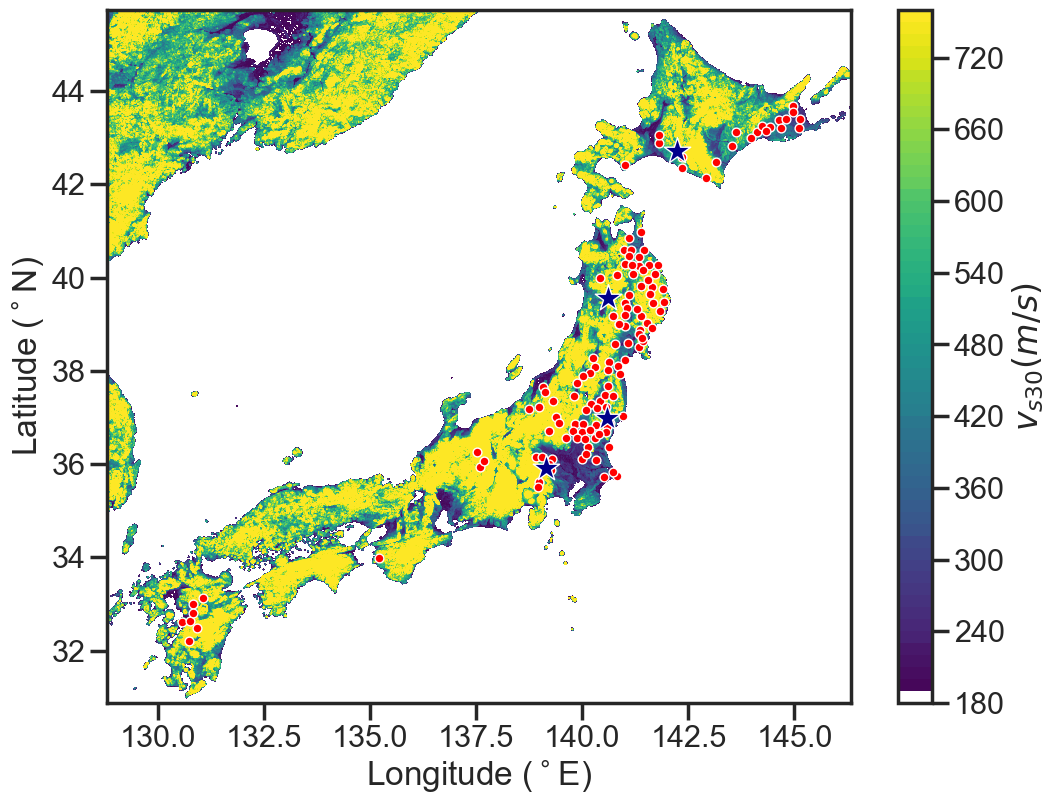

In [16]:
from matplotlib.colors import ListedColormap

xdata = scipy.io.loadmat('plotmap/xdata.mat')
ydata = scipy.io.loadmat('plotmap/ydata.mat')
vsdata = scipy.io.loadmat('plotmap/vsdata.mat')

# 设置阈值
threshold_value = 0.01

# 创建自定义颜色映射
colors = ['white' if val < threshold_value else plt.cm.viridis(val) for val in np.linspace(0, 1, 64)]
my_cmap = ListedColormap(colors)

X, Y = np.meshgrid(xdata['xdata'], ydata['ydata'])
plt.figure(figsize=(12, 9))
# plt.plot([1, 2, 3, 6], [4, 6,7,8])
plt.contourf(X, Y, vsdata['vsdata'], cmap=my_cmap, levels=64)
cbar = plt.colorbar()
cbar.set_label('$v_{s30} (m/s)$')
plt.xlabel('Longitude ($^\circ$E)')
plt.ylabel('Latitude ($^\circ$N)')
for sta in data_set.event_list.keys():
    plt.scatter(stations_pos[sta][0], stations_pos[sta][1], marker='o', c='r', s=40, edgecolors='white', linewidths=1)

slec_sta = ['FKSH13', 'HDKH01', 'SITH07', 'AKTH17']
for sta in slec_sta:
    plt.scatter(stations_pos[sta][0], stations_pos[sta][1], marker='*', c='darkblue', s=400, edgecolors='white', linewidths=1)
plt.savefig('paper_figs/station_pos.png', dpi=300, bbox_inches='tight')

## 台站波速图

In [17]:
def get_vsvp_fig(fpath, station, plot=0):
    v_profile = getProfile(os.path.join(fpath, 'sitedat_vs_vp', station + '.dat'))
    hm = 1000
    depth = v_profile[:-1, 0].repeat(2)
    depth = np.append(depth, hm)
    depth = np.insert(depth, 0, 0)
    vp = v_profile[:, 1].repeat(2)
    vs = v_profile[:, 2].repeat(2)
    if plot == 1:
        plt.figure(figsize=(4, 8))
        plt.plot(vs, depth, linewidth=1)
        plt.ylim([1, 500])
        plt.gca().invert_yaxis()
        plt.gca().xaxis.tick_top()
        plt.yscale('log')
        plt.xlabel('$v_s (m/s)$')
        plt.ylabel('Depth (m)')
        # plt.gca().spines['right'].set_visible(False)
        # plt.gca().spines['bottom'].set_visible(False)
        plt.gca().xaxis.set_label_position('top')
    return depth, vs, vp

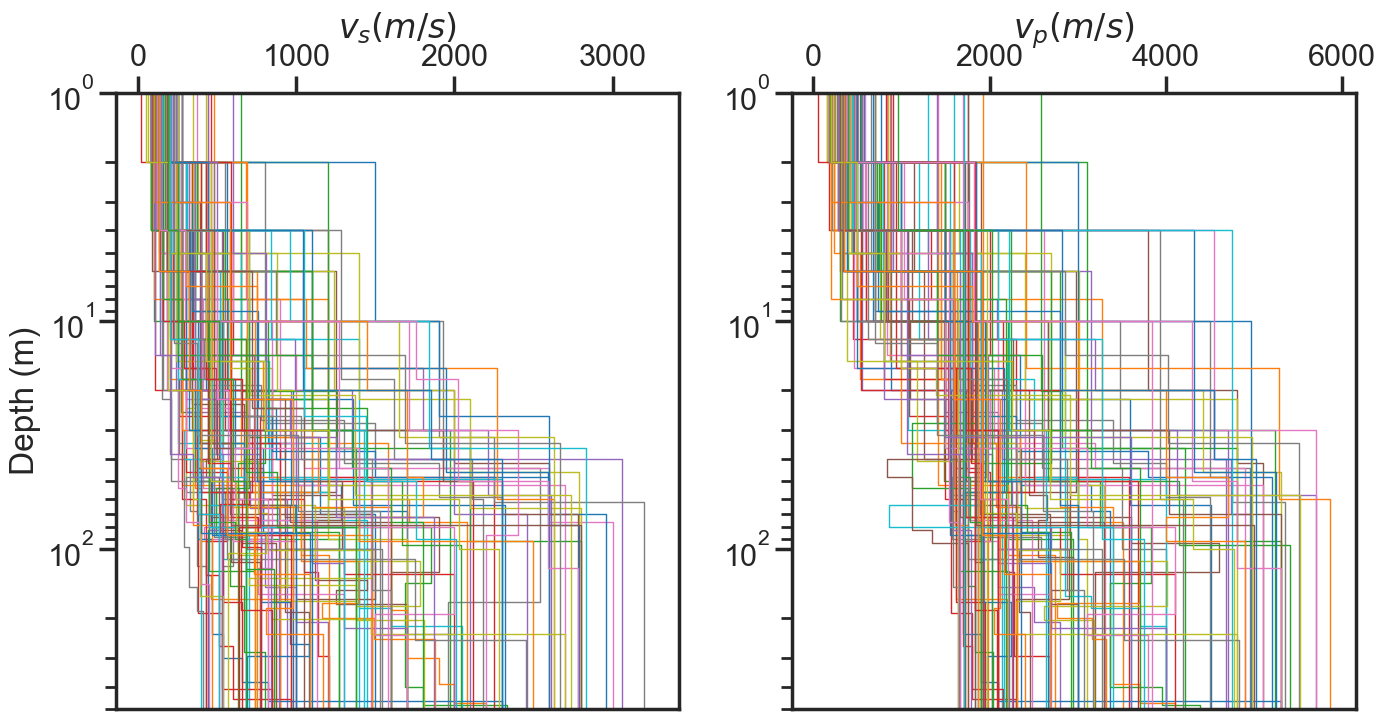

In [21]:
fpath = 'E:/Ground_motion_database/KiK-net'

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
for sta in list(data_set.event_list.keys()):
    depth, vs, vp = get_vsvp_fig(fpath, sta)
    plt.plot(vs, depth, linewidth=1)
plt.ylim([1, 500])
plt.gca().invert_yaxis()
plt.gca().xaxis.tick_top()
# plt.xscale('log')
plt.yscale('log')
plt.xlabel('$v_s (m/s)$')
plt.ylabel('Depth (m)')
# plt.gca().spines['right'].set_visible(False)
# plt.gca().spines['bottom'].set_visible(False)
plt.gca().xaxis.set_label_position('top')
plt.subplot(1, 2, 2)
for sta in list(data_set.event_list.keys()):
    depth, vs, vp = get_vsvp_fig(fpath, sta)
    plt.plot(vp, depth, linewidth=1)
plt.ylim([1, 500])
plt.gca().invert_yaxis()
plt.gca().xaxis.tick_top()
plt.yscale('log')
plt.xlabel('$v_p (m/s)$')
# plt.ylabel('Depth (m)')
# plt.gca().spines['right'].set_visible(False)
# plt.gca().spines['bottom'].set_visible(False)
plt.gca().xaxis.set_label_position('top')
plt.savefig('paper_figs/vsvp_profile.svg', dpi=300, bbox_inches='tight')

## 台站的传递函数分布图

In [ ]:
nums = 3
freq = np.logspace(np.log10(0.1), np.log10(25), 500)
pbar = tqdm(data_set.out_data.items(), desc='Ploting', ncols=100)
for sta, FTS_up in pbar:
    pbar.set_description(sta)
    predominant = np.zeros((nums, 2))
    FTS_dh = data_set.inp_data[0][sta]
    FTS_amp = FTS_up / FTS_dh
    FTS_amp_mean = np.exp(np.mean(np.log(FTS_amp + 1e-6), axis=0))
    FTS_amp_std = np.exp(np.std(np.log(FTS_amp + 1e-6), axis=0))
    peaks, per = scipy.signal.find_peaks(FTS_amp_mean.ravel(), prominence=0.01)
    if len(peaks) >= nums:
        peaks = peaks[per['prominences'].argsort()[-nums:]]
        predominant[:, 0] = freq[peaks]
        predominant[:, 1] = FTS_amp_mean[peaks].ravel()
    else:
        peaks = peaks[per['prominences'].argsort()]
        predominant[:len(peaks), 0] = freq[peaks]
        predominant[:len(peaks), 1] = FTS_amp_mean[peaks]  .ravel()

    plt.figure(figsize=(8, 6))
    for i in range(FTS_amp.shape[0]):
        plt.loglog(freq, FTS_amp[i, :], 'silver', linewidth=0.5)
    plt.loglog(freq, FTS_amp[-1, :], 'silver', linewidth=0.5, label='Events')
    plt.loglog(freq, FTS_amp_mean, 'r', linewidth=2, label='Mean')
    plt.loglog(freq, np.exp(np.log(FTS_amp_mean) + np.log(FTS_amp_std)), 'k--', linewidth=1.5)
    plt.loglog(freq, np.exp(np.log(FTS_amp_mean) - np.log(FTS_amp_std)), 'k--', linewidth=1.5, label='$\pm$ std')
    plt.scatter(freq[peaks], FTS_amp_mean[peaks], s=50, c='b', marker='*', zorder=3)
    plt.xlim([np.min(freq), np.max(freq)])
    plt.ylim([0.5, np.exp(1.2 * (np.max(np.log(FTS_amp_mean) + np.log(FTS_amp_std))))])
    plt.xlabel('Freq (Hz)')
    plt.ylabel('Amp.')
    plt.legend()
    plt.savefig(os.path.join('FTS_select', 'Class%s-%s.svg' % (station_type[sta], sta)), bbox_inches='tight')
    plt.close()

## 绘制PGA、震级、震中距和震源深度的分布图

In [ ]:
PGA, Mag, Rup, Dep = [], [], [], []
pbar = tqdm(data_set.event_list.items(), desc='Cacu', ncols=100)
for sta, events in pbar:
    pbar.set_description(sta)
    for ev in events:
        EW2 = event_data[event_data['Record code'] == ev]['PGA-EW2 (g)']
        NS2 = event_data[event_data['Record code'] == ev]['PGA-NS2 (g)']
        PGA.append(np.sqrt(EW2 * NS2))
        Mag.append(source[ev][0, 0])
        Rup.append(np.exp(source[ev][2, 0]))
        Dep.append(np.exp(source[ev][1, 0]))
PGA, Mag, Rup, Dep = np.array(PGA).ravel(), np.array(Mag).ravel(), np.array(Rup).ravel(), np.array(Dep).ravel()

### PGA-震级

In [ ]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
g = sns.JointGrid(x=Mag, y=PGA, height=8, ratio=5)
g.plot_joint(sns.scatterplot, color=colors[0], s=50, edgecolor='w')
# g.ax_marg_x.hist(np.log(PGA), bins=20, color='blue', alpha=0.7, orientation='horizontal')
g.plot_marginals(sns.histplot, kde=True, color=colors[0], edgecolor='k')
g.set_axis_labels(xlabel='Magnitude', ylabel='PGA (g)')
# g.ax_joint.set_xscale('log')
g.ax_joint.set_yscale('log')
g.ax_joint.set_ylim([0.002, 1])
plt.savefig('PGA-Mag1.svg', dpi=300, bbox_inches='tight')

g = sns.JointGrid(x=Mag, y=np.log(PGA), height=8, ratio=5)
g.plot_joint(sns.scatterplot, color=colors[0], s=50, edgecolor='w')
# g.ax_marg_x.hist(np.log(PGA), bins=20, color='blue', alpha=0.7, orientation='horizontal')
g.plot_marginals(sns.histplot, kde=True, color=colors[0], edgecolor='k')
g.set_axis_labels(xlabel='Magnitude', ylabel='PGA (g)')
g.ax_joint.set_ylim([np.log(0.002), 0])
plt.savefig('PGA-Mag2.svg', dpi=300, bbox_inches='tight')

### PGA-震源深度

In [ ]:
'Depth (km)', 'Epicentral distance (km)'

In [ ]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
g = sns.JointGrid(x=Dep, y=PGA, height=8, ratio=5)
g.plot_joint(sns.scatterplot, color=colors[1], s=50, edgecolor='w')
# g.ax_marg_x.hist(np.log(PGA), bins=20, color='blue', alpha=0.7, orientation='horizontal')
g.plot_marginals(sns.histplot, kde=True, color=colors[1], edgecolor='k')
g.set_axis_labels(xlabel='Depth (km)', ylabel='PGA (g)')
g.ax_joint.set_xscale('log')
g.ax_joint.set_yscale('log')
g.ax_joint.set_xlim([1.1, 1000])
g.ax_joint.set_ylim([0.002, 1])
plt.savefig('PGA-Dep1.svg', dpi=300, bbox_inches='tight')

g = sns.JointGrid(x=np.log(Dep), y=np.log(PGA), height=8, ratio=5)
g.plot_joint(sns.scatterplot, color=colors[1], s=50, edgecolor='w')
# g.ax_marg_x.hist(np.log(PGA), bins=20, color='blue', alpha=0.7, orientation='horizontal')
g.plot_marginals(sns.histplot, kde=True, color=colors[1], edgecolor='k')
g.set_axis_labels(xlabel='Depth (km)', ylabel='PGA (g)')
g.ax_joint.set_xlim([np.log(1.1), np.log(1000)])
g.ax_joint.set_ylim([np.log(0.002), 0])
plt.savefig('PGA-Dep2.svg', dpi=300, bbox_inches='tight')

### PGA-震中距

In [ ]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
g = sns.JointGrid(x=Rup, y=PGA, height=8, ratio=5)
g.plot_joint(sns.scatterplot, color=colors[2], s=50, edgecolor='w')
# g.ax_marg_x.hist(np.log(PGA), bins=20, color='blue', alpha=0.7, orientation='horizontal')
g.plot_marginals(sns.histplot, kde=True, color=colors[2], edgecolor='k')
g.set_axis_labels(xlabel='Epicentral distance (km)', ylabel='PGA (g)')
g.ax_joint.set_xscale('log')
g.ax_joint.set_yscale('log')
g.ax_joint.set_xlim([1, 2000])
g.ax_joint.set_ylim([0.002, 1])
plt.savefig('PGA-Rup1.svg', dpi=300, bbox_inches='tight')

g = sns.JointGrid(x=np.log(Rup), y=np.log(PGA), height=8, ratio=5)
g.plot_joint(sns.scatterplot, color=colors[2], s=50, edgecolor='w')
# g.ax_marg_x.hist(np.log(PGA), bins=20, color='blue', alpha=0.7, orientation='horizontal')
g.plot_marginals(sns.histplot, kde=True, color=colors[2], edgecolor='k')
g.set_axis_labels(xlabel='Epicentral distance (km)', ylabel='PGA (g)')
g.ax_joint.set_xlim([np.log(1), np.log(2000)])
g.ax_joint.set_ylim([np.log(0.002), 0])
plt.savefig('PGA-Rup2.svg', dpi=300, bbox_inches='tight')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 生成一些示例数据
data = np.loadtxt('Hyper-parameters/hyper-parameters.out')
# 创建色阶图
plt.figure(figsize=(10, 6))
plt.imshow(data, cmap='rainbow_r', interpolation='nearest', aspect='auto', alpha=0.7)

# 添加颜色条（colorbar）
cbar = plt.colorbar()

# 添加标题和标签
plt.yticks(np.arange(5), np.arange(11, 21, 2))
plt.xticks(np.arange(5), [256, 512, 1024, 2048, 4096])
plt.xlabel('batch size')
plt.ylabel('kernel size')

# 在每个色块上标注数值
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        plt.text(j, i, f'{data[i, j]:.4f}', ha='center', va='center', color='k')
